In [4]:
!pip install mani-skill2

In [8]:
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill2.envs

In [9]:
env_id = "PickCube"

In [10]:
from mani_skill2.utils.wrappers import RecordEpisode

obs_mode = "rgbd"
control_mode = "pd_ee_delta_pose"
env = gym.make(env_id, obs_mode=obs_mode, control_mode=control_mode, render_mode="cameras")
# RecordEpisode wrapper auto records a new video once an episode is completed
env = RecordEpisode(env, output_dir=f"logs/rgbd_{env_id}/videos")
obs, _ = env.reset(seed=42)

/home/akopyane/Desktop/dllab3/.conda/lib/python3.11/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `PickCube-v0` instead of the unversioned environment `PickCube`.
  logger.warn(
2024-07-15 12:50:40,921 - mani_skill2 - WARNING - mani_skill2 is not installed with git.
/home/akopyane/Desktop/dllab3/.conda/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_state` for environment variables or `env.get_wrapper_attr('get_state')` that will search the reminding wrappers.
  logger.warn(


In [14]:
obs['image'].keys()

odict_keys(['base_camera', 'hand_camera'])

In [18]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 26.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━

In [22]:
import torch, math

In [32]:
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import collections
# import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

# env import
import gymnasium as gym
from gymnasium import spaces



#import cv2
#import skimage.transform as st
from IPython.display import Video
import os

/home/akopyane/Desktop/dllab3/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
!pip install torchvision diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.0/785.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.8 MB/s eta 0:00:00


In [26]:
from torch import nn
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        # print("number of parameters: {:e}".format(
        #     sum(p.numel() for p in self.parameters()))
        # )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x

In [27]:
import torchvision
from collections.abc import Callable

def get_resnet(name:str, weights=None, **kwargs) -> nn.Module:
    """
    name: resnet18, resnet34, resnet50
    weights: "IMAGENET1K_V1", None
    """
    # Use standard ResNet implementation from torchvision
    func = getattr(torchvision.models, name)
    resnet = func(weights=weights, **kwargs)

    # remove the final fully connected layer
    # for resnet18, the output dim should be 512
    resnet.fc = torch.nn.Identity()
    return resnet


def replace_submodules(
        root_module: nn.Module,
        predicate: Callable[[nn.Module], bool],
        func: Callable[[nn.Module], nn.Module]) -> nn.Module:
    """
    Replace all submodules selected by the predicate with
    the output of func.

    predicate: Return true if the module is to be replaced.
    func: Return new module to use.
    """
    if predicate(root_module):
        return func(root_module)

    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    for *parent, k in bn_list:
        parent_module = root_module
        if len(parent) > 0:
            parent_module = root_module.get_submodule('.'.join(parent))
        if isinstance(parent_module, nn.Sequential):
            src_module = parent_module[int(k)]
        else:
            src_module = getattr(parent_module, k)
        tgt_module = func(src_module)
        if isinstance(parent_module, nn.Sequential):
            parent_module[int(k)] = tgt_module
        else:
            setattr(parent_module, k, tgt_module)
    # verify that all modules are replaced
    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    assert len(bn_list) == 0
    return root_module

def replace_bn_with_gn(
    root_module: nn.Module,
    features_per_group: int=16) -> nn.Module:
    """
    Relace all BatchNorm layers with GroupNorm.
    """
    replace_submodules(
        root_module=root_module,
        predicate=lambda x: isinstance(x, nn.BatchNorm2d),
        func=lambda x: nn.GroupNorm(
            num_groups=x.num_features//features_per_group,
            num_channels=x.num_features)
    )
    return root_module


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

In [164]:
vision_encoder_1 = get_resnet('resnet18')
vision_encoder_2 = get_resnet('resnet18')

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder_1 = replace_bn_with_gn(vision_encoder_1)
vision_encoder_2 = replace_bn_with_gn(vision_encoder_2)

# ResNet18 has output dim of 512
vision_feature_dim = 512
# agent_pos is 2 dimensional
lowdim_obs_dim = 9
# observation feature has 514 dims in total per step
obs_dim = 2 * vision_feature_dim + 2 * lowdim_obs_dim
action_dim = 7

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# the final arch has 2 parts
nets = nn.ModuleDict({
    'vision_encoder_1': vision_encoder_1.to(device),
    'vision_encoder_2': vision_encoder_2.to(device),
    'noise_pred_net': noise_pred_net.to(device)
})

# demo
with torch.no_grad():
    # example inputs
    image = torch.zeros((1, obs_horizon,8,96,96))
    image_1 = image[:, :, [0, 1, 2], :, :].to(device)

    image_2 = image[:, :, [5, 6, 7], :, :].to(device)
    agent_pos = torch.zeros((1, obs_horizon, 9)).to(device)
    agent_vel = torch.zeros((1, obs_horizon, 9)).to(device)
    # vision encoder
    image_features_1 = nets['vision_encoder_1'](
        image_1.flatten(end_dim=1))
    image_features_2 = nets['vision_encoder_2'](
        image_2.flatten(end_dim=1))
    # (2,512)
    image_features_1 = image_features_1.reshape(*image_1.shape[:2],-1)
    image_features_2 = image_features_2.reshape(*image_2.shape[:2],-1)
    # (1,2,512)
    obs = torch.cat([image_features_1, image_features_2, agent_pos, agent_vel],dim=-1)
    # (1,2,514)

    noised_action = torch.randn((1, pred_horizon, action_dim)).to(device)
    diffusion_iter = torch.zeros((1,)).to(device)

    # the noise prediction network
    # takes noisy action, diffusion iteration and observation as input
    # predicts the noise added to action
    noise = nets['noise_pred_net'](
        sample=noised_action,
        timestep=diffusion_iter,
        global_cond=obs.flatten(start_dim=1))

    # illustration of removing noise
    # the actual noise removal is performed by NoiseScheduler
    # and is dependent on the diffusion noise schedule
    denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = nets.to(device)

In [159]:
ls /home/akopyane/Downloads/

 16epochs.pth                       'training_with_rgb_(1).ipynb'
 DL_LAB24__Exercises-3.pdf           trajectory.rgbd.pd_ee_delta_pose.h5
 DL_LAB24_Exercises-3.tar.gz         trajectory.rgbd.pd_ee_delta_pose.json
 ManiSkill2-docs-main.zip            with_vel
 Miniconda3-latest-Linux-x86_64.sh


In [166]:
state_dict = torch.load('/home/akopyane/Downloads/with_vel')
nets.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for ModuleDict:
	size mismatch for noise_pred_net.mid_modules.0.cond_encoder.1.weight: copying a param with shape torch.Size([2048, 2322]) from checkpoint, the shape in current model is torch.Size([2048, 2340]).
	size mismatch for noise_pred_net.mid_modules.1.cond_encoder.1.weight: copying a param with shape torch.Size([2048, 2322]) from checkpoint, the shape in current model is torch.Size([2048, 2340]).
	size mismatch for noise_pred_net.up_modules.0.0.cond_encoder.1.weight: copying a param with shape torch.Size([1024, 2322]) from checkpoint, the shape in current model is torch.Size([1024, 2340]).
	size mismatch for noise_pred_net.up_modules.0.1.cond_encoder.1.weight: copying a param with shape torch.Size([1024, 2322]) from checkpoint, the shape in current model is torch.Size([1024, 2340]).
	size mismatch for noise_pred_net.up_modules.1.0.cond_encoder.1.weight: copying a param with shape torch.Size([512, 2322]) from checkpoint, the shape in current model is torch.Size([512, 2340]).
	size mismatch for noise_pred_net.up_modules.1.1.cond_encoder.1.weight: copying a param with shape torch.Size([512, 2322]) from checkpoint, the shape in current model is torch.Size([512, 2340]).
	size mismatch for noise_pred_net.down_modules.0.0.cond_encoder.1.weight: copying a param with shape torch.Size([512, 2322]) from checkpoint, the shape in current model is torch.Size([512, 2340]).
	size mismatch for noise_pred_net.down_modules.0.1.cond_encoder.1.weight: copying a param with shape torch.Size([512, 2322]) from checkpoint, the shape in current model is torch.Size([512, 2340]).
	size mismatch for noise_pred_net.down_modules.1.0.cond_encoder.1.weight: copying a param with shape torch.Size([1024, 2322]) from checkpoint, the shape in current model is torch.Size([1024, 2340]).
	size mismatch for noise_pred_net.down_modules.1.1.cond_encoder.1.weight: copying a param with shape torch.Size([1024, 2322]) from checkpoint, the shape in current model is torch.Size([1024, 2340]).
	size mismatch for noise_pred_net.down_modules.2.0.cond_encoder.1.weight: copying a param with shape torch.Size([2048, 2322]) from checkpoint, the shape in current model is torch.Size([2048, 2340]).
	size mismatch for noise_pred_net.down_modules.2.1.cond_encoder.1.weight: copying a param with shape torch.Size([2048, 2322]) from checkpoint, the shape in current model is torch.Size([2048, 2340]).

In [161]:
ema_nets = nets

In [38]:
nets

ModuleDict(
  (vision_encoder_1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(4, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(4, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(4, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(4, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [59]:
obs['image']['hand_camera']['rgb'].shape

(128, 128, 3)

In [113]:

obs_deque = collections.deque(
    [ (obs['image']['hand_camera']['rgb'], obs['image']['base_camera']['rgb'],obs['agent']['qpos'])  * obs_horizon], maxlen=obs_horizon)


In [119]:
obs_deque = collections.deque(
    [(np.copy(obs['image']['hand_camera']['rgb']),
      np.copy(obs['image']['base_camera']['rgb']),
      np.copy(obs['agent']['qpos'])) for _ in range(16)],
    maxlen=16
)

In [114]:
len(obs_deque)

16

In [116]:
for i in range(2):
    print(obs_deque[i].shape)

(9,)
(128, 128, 3)


In [120]:
agent_pos = np.stack([x[2] for x in obs_deque])
print(agent_pos.shape)

(16, 9)


In [90]:
images_1 = np.stack([x[0]/255 for x in obs_deque])
images_1.shape

(1, 128, 128, 3)

In [91]:
len(obs_deque)

1

In [136]:
!pip install ffmpeg scikit-video

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=760a4381bd2c6fc4d3973c4e617397c265ffb747af07301ced1358081e731ebd
  Stored in directory: /home/akopyane/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [162]:
max_steps = 200

# use a seed >200 to avoid initial states seen in the training dataset
env = gym.make("PickCube-v0", obs_mode="rgbd", render_mode = 
            'cameras', control_mode = 'pd_ee_delta_pose')
#env.unwrapped.print_sim_details()
#env.seed(100000)

# limit enviornment interaction to 200 steps before termination
max_steps = 200
# use a seed >200 to avoid initial states seen in the training dataset
#env.seed(100000)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [(np.copy(obs['image']['hand_camera']['rgb']),
      np.copy(obs['image']['base_camera']['rgb']),
      np.copy(obs['agent']['qpos']),
      np.copy(obs['agent']['qvel'])) for _ in range(obs_horizon)],
    maxlen=obs_horizon
)
# save visualization and rewards
imgs = []
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon number of observations
        images_1 = np.stack([x[0]/255 for x in obs_deque])
        images_2 = np.stack([x[0]/255 for x in obs_deque])


        images_1 = torch.from_numpy(images_1).to(device, dtype=torch.float32)
        images_2 = torch.from_numpy(images_2).to(device, dtype=torch.float32)

        agent_pos = np.stack([x[2] for x in obs_deque])
        agent_pos = torch.from_numpy(agent_pos).to(device, dtype=torch.float32).squeeze()
        agent_vel =  np.stack([x[3] for x in obs_deque])
        agent_vel = torch.from_numpy(agent_vel).to(device, dtype=torch.float32).squeeze()
        

        # normalize observation
        # nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        # images are already normalized to [0,1]


        # device transfer

        # infer action
        with torch.no_grad():
            # get image features

            # vision encoder
            image_features_1 = nets['vision_encoder_1'](
                image_1.flatten(end_dim=1))
            image_features_2 = nets['vision_encoder_2'](
                image_2.flatten(end_dim=1))

            # (2,512)
            image_features_1 = image_features_1.reshape(*image_1.shape[:2],-1).squeeze()
            image_features_2 = image_features_2.reshape(*image_2.shape[:2],-1).squeeze()
            # (1,2,512)

            obs = torch.cat([image_features_1, image_features_2, agent_pos, agent_vel],dim=-1)

            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = obs.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = torch.randn(
                (B, pred_horizon, action_dim), device=device)
            naction = noisy_action

            # init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = ema_nets['noise_pred_net'](
                    sample=naction,
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred =naction

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append((np.copy(obs['image']['hand_camera']['rgb']),
                    np.copy(obs['image']['base_camera']['rgb']),
                    np.copy(obs['agent']['qpos']),
                    np.copy(obs['agent']['qvel'])))
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render())

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break
# print out the maximum target coverage
print('Score: ', max(rewards))

[2024-07-15 16:15:39.444] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2340 and 2322x512)

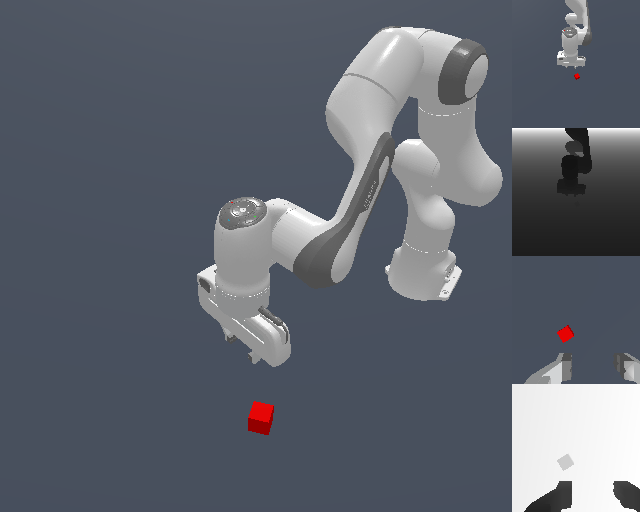

In [151]:
from PIL import Image
from IPython.display import display, Image as IPImage
import io

images = [Image.fromarray(img) for img in imgs]

# Save to a bytes buffer
buffer = io.BytesIO()
images[0].save(buffer, format='GIF', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)
buffer.seek(0)

